## Import CSV

In [10]:
import pandas
def read_csv(filename,folder):
    folder=folder+"/"+filename+".csv"
    return pandas.read_csv(folder,encoding='ISO-8859-1')

In [23]:
folder="/root/"
data=read_csv(filename="WEN",folder=folder)
data.columns = ( 'DATE','vfx','vix' ,'vbx', 'vmt','rwm','dog','psh', 'spx')
data = data.fillna(method='ffill')
data.tail()

,DATE,vfx,vix,vbx,vmt,rwm,dog,psh,spx
499,2017-09-06,215.304565,11.63,10.022372,25.482641,45.358208,66.359299,31.931274,4777.689941
500,2017-09-05,214.626022,12.23,10.040814,25.362762,45.465393,66.593506,32.047920,4762.750000
501,2017-09-01,216.256409,10.13,9.994713,25.531948,45.056149,65.812805,31.795191,4798.990234
502,2017-08-31,215.804016,10.59,10.013153,25.402401,45.260769,65.929901,31.872953,4789.180176
503,2017-08-30,214.569443,11.22,9.983647,25.105610,45.747974,66.125107,32.038193,4761.720215


In [12]:
data.shape

(504, 9)

## Visualize Data

In [13]:
from matplotlib import pyplot
def plot_data(dataset,groups):
    i = 1
    pyplot.figure()
    values = dataset.values
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

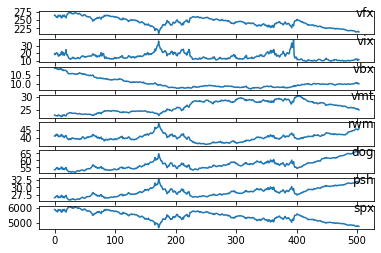

In [14]:
plot_data(data,groups=list(range(1,9)))

## Data Summary

In [15]:
data.describe()

,vfx,vix,vbx,vmt,rwm,dog,psh,spx
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,244.395805,15.333413,10.017343,26.430865,40.405756,57.019953,28.412942,5431.560540
std,13.908723,4.533763,0.286577,2.149230,2.195040,3.233095,1.507878,312.578747
min,210.128433,9.140000,9.683455,22.548750,36.076992,51.579994,25.667391,4672.660156
25%,235.074059,12.175000,9.805305,24.422805,39.192882,54.586658,27.226387,5222.270142
50%,244.253342,14.455000,9.943701,26.665625,40.392239,56.529932,28.301810,5430.175049
75%,255.819534,17.884999,10.096783,28.382936,41.760325,58.581785,29.345070,5685.679932
max,273.387878,37.320000,10.912119,30.474449,48.979759,66.593506,32.930397,6083.819824


## Independent and identically distributed (I.I.D.) Testing

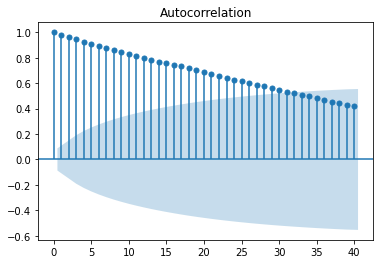

In [22]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.graphics.tsa.plot_acf(data['vfx'].values, lags=40)
#print(data['VFINX'])
#sm.graphics.tsa.plot_acf(data['VIX_SKW'].values, lags=40)
plt.show()

## Histogram

<AxesSubplot:ylabel='Frequency'>

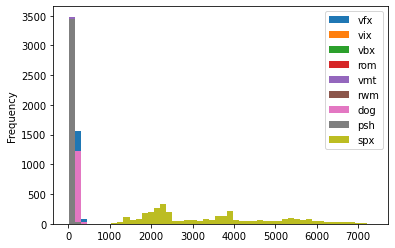

In [70]:
data.plot(kind="hist",bins=50)

## Normal Test 

In [57]:
from scipy import stats
print(stats.shapiro(data['vfx'].values))
print(stats.shapiro(data['spx'].values))

ShapiroResult(statistic=0.9248300194740295, pvalue=1.1945661630515947e-38)
ShapiroResult(statistic=0.9236187934875488, pvalue=6.955494866611912e-39)


## *** LSTM ***

In [58]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
def Standard_MinMax(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    return sc.fit_transform(data.reshape(-1,1))

In [59]:
folder="/root/bigdataanalysis/test/"
data=read_csv(filename="FEAT_DATA",folder=folder)
data.columns = ( 'DATE','vfx' ,'vix' ,'vbx' ,'rom', 'vmt','rwm','dog','psh', 'spx')
del data['DATE']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
data.shape


(3483, 9)

## Series to Supervised

In [61]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [62]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()
reframed.shape

(248, 18)

In [32]:
pred = {'vfx': 8}
reframed = pandas.concat([reframed.iloc[:,0:10],reframed.iloc[:,pred['vfx']]],axis=1)
reframed.head()
reframed.shape

(248, 19)

In [33]:
len(reframed.values)

248

## Data Split

In [34]:
train = reframed.values[:100,:]
test = reframed.values[100:169,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((100, 18), (100,), (69, 18), (69,))

## LSTM

In [35]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

import keras
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 13,851
Trainable params: 13,851
Non-trainable params: 0
_________________________________________________________________


## Training

In [36]:
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/100
2/2 [==============================] - 0s 174ms/step - loss: 0.8336 - val_loss: 0.5005
Epoch 2/100
2/2 [==============================] - 0s 9ms/step - loss: 0.7523 - val_loss: 0.4445
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6759 - val_loss: 0.3922
Epoch 4/100
2/2 [==============================] - 0s 32ms/step - loss: 0.6039 - val_loss: 0.3435
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 0.5364 - val_loss: 0.2982
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 0.4731 - val_loss: 0.2562
Epoch 7/100
2/2 [==============================] - 0s 31ms/step - loss: 0.4139 - val_loss: 0.2175
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3588 - val_loss: 0.1821
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 0.3077 - val_loss: 0.1500
Epoch 10/100
2/2 [==============================] - 0s 35ms/step - loss: 0.2606 - val_loss: 0.1211
Epoch 11/100
2/2 [======

## Plot Loss Curve

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


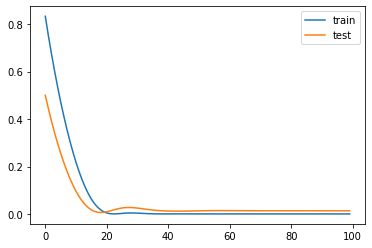

In [37]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [38]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
yhat.shape, test_X.shape

((69, 1), (69, 18))

## Invert scaling for forecast

In [39]:
pred = {'vfx': 0}
pred,pred['vfx']
test_X

array([[0.86768039, 0.25057782, 0.95356064, ..., 0.01176902, 0.01563077,
        0.87319765],
       [0.87327075, 0.25057782, 0.94617421, ..., 0.01020416, 0.01464226,
        0.88136086],
       [0.88144384, 0.22664852, 0.94063456, ..., 0.01294266, 0.01643394,
        0.86877677],
       ...,
       [0.84287171, 0.31067299, 0.92272189, ..., 0.03802207, 0.03951375,
        0.80100099],
       [0.80150195, 0.3763426 , 0.92639347, ..., 0.03310363, 0.03500796,
        0.82919157],
       [0.82979833, 0.33011553, 0.90987099, ..., 0.04180049, 0.04247646,
        0.78498109]])

In [40]:
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred['vfx'], axis=1)), axis=1)
inv_yhat.shape

(69, 18)

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape


(69,)

## Invert scaling for actual

In [42]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred['vfx'], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(69,)

## RMSE

In [43]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.027


In [44]:
#inv_y = np.cumprod(inv_y+1)
#inv_yhat = np.cumprod(inv_yhat+1)
inv_y,inv_yhat

(array([0.94416506, 0.94547539, 0.94739783, 0.94443427, 0.93815373,
        0.93891059, 0.93565188, 0.93371478, 0.93282481, 0.93166713,
        0.93213185, 0.92871636, 0.92591975, 0.92534711, 0.92710786,
        0.92332503, 0.92568437, 0.91872628, 0.91784234, 0.9237202 ,
        0.92367845, 0.91990314, 0.91730993, 0.91882931, 0.91685687,
        0.91593229, 0.92217939, 0.9242496 , 0.91840069, 0.91955723,
        0.9163504 , 0.91335714, 0.91345527, 0.9086347 , 0.91527319,
        0.91921733, 0.9134534 , 0.91220999, 0.91700651, 0.91050375,
        0.91266156, 0.90957881, 0.90258426, 0.90290949, 0.88948625,
        0.89239304, 0.88803794, 0.89678198, 0.89998504, 0.89342512,
        0.9002144 , 0.88836542, 0.88620159, 0.87009792, 0.87527117,
        0.88324367, 0.88236573, 0.89240657, 0.88144231, 0.90631898,
        0.88861433, 0.90853393, 0.91930042, 0.90890918, 0.92616939,
        0.93010903, 0.93818418, 0.92847309, 0.93511197]),
 array([0.93825155, 0.93717008, 0.93531081, 0.93344405, 0.

## Predict vs Real

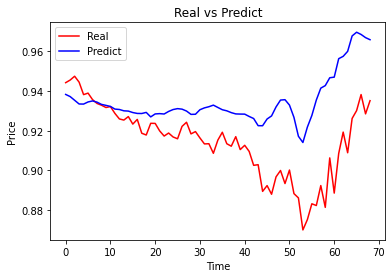

In [45]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## CNN Data Split (same with LSTM)

In [46]:
train = reframed.values[:100,:]
test = reframed.values[100:169,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((100, 18), (100,), (69, 18), (69,))

## CNN Data Split

In [47]:
from keras.layers import Activation, Dense
model = keras.Sequential()
model.add(Dense(5, activation='relu', input_shape=(8,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae','mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


## Training

In [48]:
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Epoch 1/100


ValueError: in user code:

    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape [None, 18]


## Plot Loss Curve

In [ ]:
%pylab inline
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Predict

In [ ]:
yhat = model.predict(test_X)
yhat.shape, test_X.shape

In [ ]:
pred = {'VFINX': 0}
inv_yhat = concatenate((yhat, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

In [ ]:
real = test_y.reshape((len(test_y), 1))
inv_y = concatenate((real, numpy.delete(test_X, pred['VFINX'], axis=1)), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
inv_y = np.cumprod(inv_y+1)
inv_yhat = np.cumprod(inv_yhat+1)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real')
plt.plot(inv_yhat, color = 'blue', label = 'Predict')
plt.title('Real vs Predict')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## *** SVM Classification ***

In [ ]:
folder="C:/Users/user/Desktop/NCCU_DB/DataBase"
data=read_csv(filename="FEAT_DATA",folder=folder)
data.head()

## Data convert to Relative Change

In [ ]:
import numpy
y = data['VFINX']
#x = data[['VBMFX','VIX.chg','VIX.ret','SPX_SMA','VFINX_SKW','VBMFX_SKW','VIX_SKW']]
x = data[['VIX.ret','SPX_SMA']]
x.head()

## Y convert to Category

In [ ]:
#y = (y-y.mean())/y.std()
y = numpy.where(y>0, 1, 0)
#y = numpy.where(y>1, 1, numpy.where(y<-1, -1, 0))

In [ ]:
from sklearn.model_selection     import train_test_split
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size = 0.33, random_state = 42 )

## Standardize Function

In [ ]:
from sklearn.preprocessing       import StandardScaler
def Standard(data):
    sc = StandardScaler()
    # fit_transform will fixed mean & vol by data
    # transform reuse above mean & vol
    return sc.fit_transform(data)

In [ ]:
x = Standard(x)
x.shape

## SVM Classifier

In [ ]:
def plot_classifier(data,target,type,C=100,svc_kernel="rbf"):
    if type == 'SVC':
        from sklearn.svm import SVC
        clf = SVC(C=C,kernel=svc_kernel)
        clf.fit(data, target)
    if type == 'Logistic':
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression()
        clf.fit(data, target)
    plot_estimator(estimator=clf, data=data ,target=target)
    
def plot_estimator(estimator, data, target):
    # *** estimator model must trained by two variables ***
    x_min, x_max = data[:, 0].min() - 0.02, data[:, 0].max() + 0.02
    y_min, y_max = data[:, 1].min() - 0.02, data[:, 1].max() + 0.02
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 0.005), numpy.arange(y_min, y_max, 0.005))
    Z = estimator.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.plot()
    plt.contourf(xx, yy, Z, alpha=0.4, cmap = plt.cm.RdYlBu)
    plt.scatter(data[:, 0], data[:, 1], c=target, cmap = plt.cm.brg)
    plt.xlabel('Index Return')
    plt.ylabel('Dividend Growth')
    plt.show()

## Plot Decision Boundary

In [ ]:
import matplotlib.pyplot as plt
plot_classifier(data=x,target=y,type="SVC",svc_kernel="linear",C=100)

In [ ]:
plot_classifier(data=x[:1000,:],target=y[:1000],type="SVC",svc_kernel="linear",C=100)

In [ ]:
plot_classifier(data=x[:50,:],target=y[:50],type="SVC",svc_kernel="rbf",C=1000)

In [ ]:
plot_classifier(data=x[:1500,:],target=y[:1500],type="SVC",svc_kernel="rbf",C=1000)